In [1]:
using Distributed

In [2]:
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
@everywhere using LinearAlgebra
using MCMCDiagnostics
using SharedArrays

In [3]:
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")

In [4]:
@everywhere include(src_path*"functions_msc.jl")

In [5]:
highestDivisor(40, 9)

8

In [6]:
@everywhere include(src_path*"functions_neighbors.jl")

In [7]:
@everywhere include(src_path*"functions_types.jl")

In [8]:
L = 6
c = SystConstants(L, L, 1/0.3^2, 0.3, 1.0, 2.0/L, 0.5)
ψ₁ = State(2, c; u⁺=1.0, u⁻=1.0)
ψ₂ = State(2, c; u⁺=1.0, u⁻=1.0)
@test ψ₁ != ψ₂
save([ψ₁,ψ₂], "TEST")
addToList(ψ₁, "TEST")
ψ_list = loadStates("TEST")
ψ_list[1] == ψ₁
maxMinAmplitudes(ψ₁)
ψ_arr = StateArray("TEST")
@test ψ_arr[1] == ψ₁
@test ψ_arr[2] == ψ₂

Test Passed

In [9]:
@everywhere include(src_path*"functions_energy.jl")

In [10]:
ϕ = ψ₁.lattice[1,1,1]
nb = ψ₁.nb[1,1,1]
E(ψ₁)

1.0203278710151076e6

In [11]:
testEnDiff(ψ₁)

Checking that ΔE gives same result as E'-E on all different sites of the lattice


Test Passed

In [55]:
@everywhere include(src_path*"functions_mc.jl")

In [15]:
sim = Controls()
proposeLocalUpdate(ψ₁.lattice[1,1,1], sim)
ψ₀ = copy(ψ₁)
@test ψ₀ == ψ₁
metropolisHastingUpdate!(ψ₁, (1,1,1), sim)
ψ₀ == ψ₁
mcSweep!(ψ₁, sim)
mcSweepFrac!(ψ₁, sim)
mcSweepEn!(ψ₁, sim)
mcProposalFraction(ψ₁, sim, 100)
nMCS(ψ₁, sim, 100);

In [23]:
ψ_list = [ψ₁, ψ₀, ψ₂]
nMCSEnergy!(ψ_list, [sim, sim, sim], 10000, [E(ψ) for ψ in ψ_list]);

In [27]:
_, _, _, sim = adjustSimConstants!(sim, ψ₁);
sim

Controls(1.0471975511965976, 0.4, 0.2962962962962963, Uniform{Float64}(a=-1.0471975511965976, b=1.0471975511965976), Uniform{Float64}(a=-0.4, b=0.4), Uniform{Float64}(a=-0.2962962962962963, b=0.2962962962962963))

In [32]:
sim = Controls()
adjustSimConstants!(ψ_list, [sim, sim, sim])

([3080, 3040, 3360], [0.338079, 0.336458, 0.311458])

In [75]:
@everywhere include(src_path*"functions_thermalization.jl")

In [36]:
c

SystConstants(6, 6, 11.11111111111111, 0.3, 1.0, 0.3333333333333333, 0.5)

In [42]:
t, E₁, E₂, dE, ψ₁, ψ₂, sim₁, sim₂ = findEquilibrium(c);

Finding Equilibrium of
SystConstants(6, 6, 11.11111111111111, 0.3, 1.0, 0.3333333333333333, 0.5)
Controls(1.0471975511965976, 0.4, 3.0, Uniform{Float64}(a=-1.0471975511965976, b=1.0471975511965976), Uniform{Float64}(a=-0.4, b=0.4), Uniform{Float64}(a=-3.0, b=3.0))
Performing initial 1000 MCS
Searching for ΔE <= 0..
ΔE <= 0 found at t₀ = 1039!
Checking if average is close to 0..
0% of max
Equilibrium found at time 4540
over the interval [1039, 1500]
s.t. <ΔE> = 40.37 ± 3.3
std(ΔE) = 70.7


In [48]:
using Pkg
Pkg.add("LaTeXStrings")

 Resolving package versions...
  Updating `~/.julia/environments/v0.7/Project.toml`
  [b964fa9f] + LaTeXStrings v1.0.3
  Updating `~/.julia/environments/v0.7/Manifest.toml`
 [no changes]


In [58]:
ψ_low = State(1,c)
ψ_high = State(2,c);
ψ_w = [ψ_low for i = 1:2]
parallelThermalization!(ψ_high, ψ_w, c, sim₁)

Number of parallel workers: 3
Worker 1 initially thermalised after 243 steps
Worker 2 initially thermalised after 250 steps
All workers initially thermalized after 1001 steps
Checking average ∈ [1002, 1272]
Thermalization successful between T = [1002, 1272]
Worker 1: ΔE = 12.747516402857645 ± 48.34849035390319
Worker 2: ΔE = 8.568637703785237 ± 72.25417057340404
Final thermalization time: 1392


(1392, 1002, 1272, [1.01538e6, 9.99115e5, 9.81776e5, 965724.0, 9.48831e5, 9.3365e5, 9.18889e5, 9.02135e5, 8.85619e5, 8.72517e5  …  208.769, 226.918, 187.79, 175.05, 164.011, 163.532, 166.743, 187.309, 206.748, 191.683], [-648.0 -567.468 … 119.834 147.848; -648.0 -548.009 … 162.234 169.083], State(LatticeSite[LatticeSite([1.79327, 3.11816, 0.840546], 1.1833, 4.79115, 1.0, 0.0) LatticeSite([-6.6856, 5.60073, 0.104871], 1.21033, 3.56843, 1.0, 0.0) … LatticeSite([-3.0079, -6.4734, -0.571185], 2.07551, 3.69639, 1.0, 0.0) LatticeSite([-3.26672, -2.00052, 2.52625], 0.448994, 1.39702, 1.0, 0.0); LatticeSite([-7.60259, -1.43261, -0.970377], 3.34335, 4.13734, 1.0, 0.0) LatticeSite([1.82595, 8.01573, 4.39848], 6.07404, 2.28535, 1.0, 0.0) … LatticeSite([9.10962, 9.87884, 3.2616], 4.7051, 4.70465, 1.0, 0.0) LatticeSite([-4.55224, -2.28963, -5.57387], 1.27342, 4.81805, 1.0, 0.0); … ; LatticeSite([-5.39991, -7.50541, -3.6652], 0.506041, 3.56355, 1.0, 0.0) LatticeSite([-1.387, -1.13455, 2.44515], 0.70

In [72]:
ψ_low = State(1,c)
ψ_high = State(2,c);
ψ_w = [ψ_low for i = 1:3]
sim_w = [Controls() for i = 1:3]
t, adjust, ψ_list, sim_list, E_matrix = flatThermalization!(ψ_w, sim_w; visible=true);

Controls after initial adjustment:
State	θmax			umax	Amax
1	1.0471975511965976	0.4	0.2962962962962963
2	1.0471975511965976	0.4	0.2962962962962963
3	1.0471975511965976	0.4	0.2962962962962963
With lowest AR: 0.32835648148148144,	highest AR: 0.3395833333333333

Worker 2 not flat.	⟨ΔE⟩ = 40.29890349294595 ± 11.374968879927094
Thermalization not yet reached after 1000 MCS

All workers flat.
  ⟨ΔE⟩{1} =	-3.0644389395887544 ± 20.188513597813934
  ⟨ΔE⟩{2} =	10.673431994684478 ± 23.206025229496785
  ⟨ΔE⟩{3} =	-45.10107745758452 ± 32.075449451700344
All state energy-curves are flat after 8120

Final control constants:
State	θmax			umax	Amax
1	1.0471975511965976	0.4	0.2962962962962963
2	1.0471975511965976	0.4	0.2962962962962963
3	1.0471975511965976	0.4	0.2962962962962963
With lowest AR: 0.33865740740740746,	highest AR: 0.3438657407407407


In [77]:
thermalizeLite!(ψ_high, ψ_w, sim₁; visible=true);

Worker 1 initially thermalised after 4 steps
Worker 2 initially thermalised after 9 steps
Worker 3 initially thermalised after 17 steps
All workers initially thermalized after 17 steps

Controls after initial adjustment:
State	θmax			umax	Amax
1	1.0471975511965976	0.4	0.2962962962962963
2	1.0471975511965976	0.4	0.2962962962962963
3	1.0471975511965976	0.4	0.2962962962962963
4	1.0471975511965976	0.4	0.2962962962962963
With lowest AR: 0.3295138888888889,	highest AR: 0.34016203703703696

All workers flat.
  ⟨ΔE⟩{1} =	-54.330203091838825 ± 39.40501122127288
  ⟨ΔE⟩{2} =	-37.26290602462704 ± 77.3448531720927
  ⟨ΔE⟩{3} =	-16.418746442658218 ± 37.83444570627905
Thermalization successful between T = [1, 2500]
Worker 1: ΔE = 14.938303266900213 ± 68.26824352474034
Worker 2: ΔE = 17.26092185522538 ± 81.7408182599519
Worker 3: ΔE = 19.595796827036057 ± 64.71253417256582
Final thermalization time: 2557

Final controls:
State	θmax			umax	Amax
1	1.0471975511965976	0.4	0.2962962962962963
2	1.04719755119

In [166]:
@everywhere include(src_path*"functions_observables.jl")

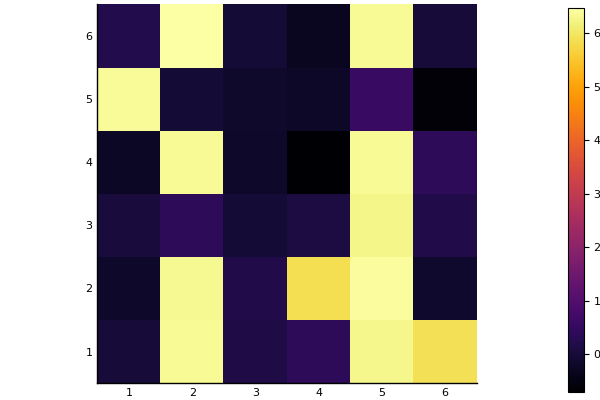

In [86]:
v1, v2 = vortexSnapshot(ψ_high);
pyplot()
heatmap(v1[:,:,1]; aspect_ratio=1)

In [87]:
function getMomMatrix(L::Int64)
    return [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L]
end

getMomMatrix (generic function with 1 method)

In [92]:
typeof(getMomMatrix(L))

Array{Array{Float64,1},2}

In [121]:
@everywhere using LinearAlgebra

Add `using LinearAlgebra` to your imports.
  likely near /home/nicolai/.julia/packages/IJulia/GIANC/src/kernel.jl:41


In [111]:
ks = getMomMatrix(L)
(S⁺, S⁻, proj_V⁺, proj_V⁻) = sfvlaMeasure!(ks, ψ_high, sim₁, 1000, 10);

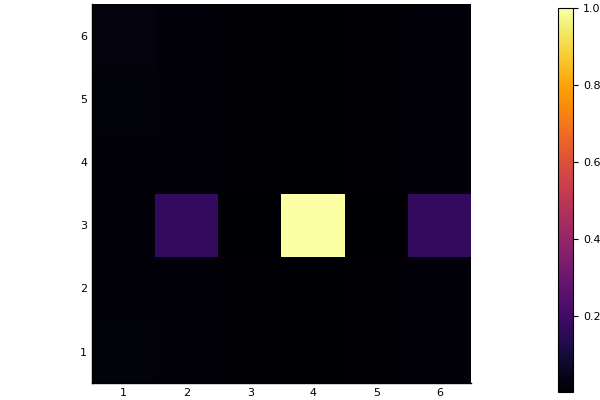

In [100]:
heatmap(avS⁺; aspect_ratio=1)

In [141]:
(av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻) = parallelSFVLA!(ks, ψ_list, sim₁, 2000, 10)

Starting 2000 measurements on 4 processes doing max 500 measurements each
on a 6×6 system, corresponding to 5000 MCS pr. process
Measurement progress: 10%
Measurement progress: 20%
Measurement progress: 30%
Measurement progress: 40%
Measurement progress: 50%
Measurement progress: 60%
Measurement progress: 70%
Measurement progress: 80%
Measurement progress: 90%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Processing.

Sum of vorticity of random snapshot:
V⁺: 	12.0
V⁻: 	12.0

Max (S⁺, S⁻)
(1.0, 1.0)
Max δ(S⁺, S⁻)
(5.18489216977095e-5, 2.4803550347777903e-6)
Max correlation time
(834.9222269410253, 1077.0515073764896)


([0.192359 0.61318 … 0.609823 0.205416; 0.184683 0.59702 … 0.599472 0.209195; … ; 0.196516 0.600733 … 0.60369 0.199423; 0.183079 0.61468 … 0.593532 0.203787], [0.000104089 0.000133484 … 0.000154565 0.000218097; 0.000106869 0.000199198 … 0.00018426 9.33887e-5; … ; 0.000106705 0.000150821 … 0.000151179 0.0001587; 8.18526e-5 0.000133778 … 0.000144113 0.000147643], Array{Float64,2}[[-0.00489712 0.845657 … 0.819973 0.174334; -0.0129759 0.844946 … 0.115392 0.330198; … ; -0.0123252 0.841563 … 0.666067 0.293519; 0.329908 0.493078 … 0.490879 0.511989], [0.336403 0.519942 … 0.488071 0.32744; -0.0191416 0.653597 … 0.670193 0.178493; … ; 0.167959 0.687758 … 0.665843 -0.0188687; 0.156563 0.665901 … 0.844909 -0.0101867], [0.147897 0.520351 … 0.655728 0.343678; -0.0105233 0.821298 … 0.47879 0.177784; … ; 0.81193 -0.164986 … 0.672229 0.14936; 0.174596 0.649612 … 0.833966 -0.0069242], [0.0216573 0.678808 … 0.661268 0.326676; 0.151884 0.686028 … 0.678124 0.157071; … ; 0.630052 0.174435 … 0.350736 0.1673

In [171]:
measurementSeries!(ψ_list, sim₁, 100, 10; filename="test")

Starting 99 measurements on 3 processes doing max 33 measurements each
on a 6×6 system giving in total 100 measurements to file
Measurements done.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/test


1

In [167]:
c⁺_list, c⁻_list, u⁺_list, u⁻_list = averageOrdParam!(ψ_list, sim₁, 10000, 10);

Starting 10000 measurements on 4 processes doing max 2500 measurements each
on a 6×6 system, corresponding to 25000 MCS pr. process
Measurement progress: 10%
Measurement progress: 20%
Measurement progress: 30%
Measurement progress: 40%
Measurement progress: 50%
Measurement progress: 60%
Measurement progress: 70%
Measurement progress: 80%
Measurement progress: 90%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Processing.


In [174]:
using SharedArrays

In [175]:
ψ_measured = loadStates("test");
measureOrdParam(ψ_measured)

([0.0308987, 0.0193568, 0.0540034, 0.0919114, 0.0365824, 0.0905631, 0.0563376, 0.0300499, 0.0245123, 0.0959984  …  0.0321995, 0.0735693, 0.0834326, 0.0358081, 0.034383, 0.0633606, 0.120644, 0.113115, 0.0740964, 0.0707828], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [195]:
@everywhere include(src_path*"functions_symmetries.jl")

In [183]:
(ρˣˣₖ₂, ρˣˣₖ₃, ρʸʸₖ₃, ρʸʸₖ₁, ρᶻᶻₖ₁, ρᶻᶻₖ₂, u⁺_array, u⁻_array, A_array, E_array, 
    ΥcosX, ΥcosY, ΥcosZ, ΥsinX, ΥsinY, ΥsinZ) = gaugeStiffnessMeasure!(ψ_high, sim₁, 100, 10);

In [185]:
length(ψ_measured)

100

In [184]:
ρˣˣₖ₂, ρˣˣₖ₃, ρʸʸₖ₁, ρʸʸₖ₃, ρᶻᶻₖ₁, ρᶻᶻₖ₂ = gaugeStiffness(ψ_measured);

In [186]:
(AVρˣˣₖ₂, SEρˣˣₖ₂, AVρˣˣₖ₃, SEρˣˣₖ₃, AVρʸʸₖ₃, SEρʸʸₖ₃, AVρʸʸₖ₁, SEρʸʸₖ₁,
AVρᶻᶻₖ₁, SEρᶻᶻₖ₁, AVρᶻᶻₖ₂, SEρᶻᶻₖ₂, AVu⁺, AVu⁻, AVA, u⁺, AVE, Υx, Υy, Υz) = parallelMeasureGS!(ψ_list, sim₁, 100, 10);

Starting 100 measurements on 4 processes on an 6x6x6 system,
            correspoding to 25 measurements and 
            250 MCS pr. process
Measurements completed, collecting results from processes
Processing results


In [190]:
(sumCosX, sumCosY, sumCosZ, sumSinX, sumSinY, sumSinZ) = helicityModulusContribution(ψ_high)

(5.7921237022056795, 10.752578336905497, 7.7617711031785515, 69.17000841843382, 189.89128479202034, 47.11613706814244)

In [192]:
Y_vec = helicityModulus(ψ_high);

In [193]:
helicityModulus2D(ψ_high)

-0.6465225551223823

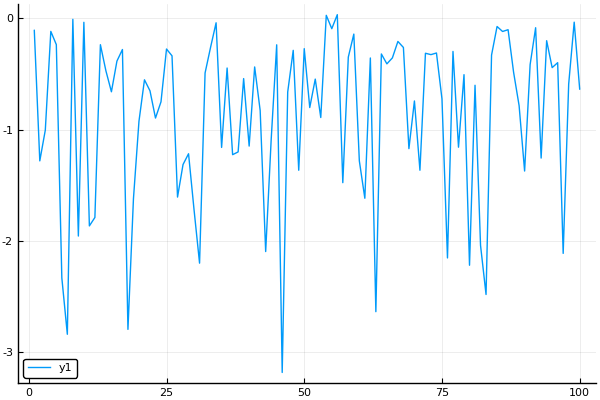

In [196]:
Υ_list = measureHelicityModulus(ψ_measured);
plot(Υ_list)

In [198]:
include(src_path*"functions_plots_and_files.jl")

┌ Warning: Deprecated syntax `parametric method syntax plotStructureFunctionVortexLattice{T <: Real, R <: Real}(avV⁺::Array{T, 2}, avV⁻::Array{T, 2}, V⁺::Array{R, 2}, V⁻::Array{R, 2}, avS⁺::Array{T, 2}, avS⁻::Array{T, 2}, ks::Array{Array{T, 1}, 2})` around /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_plots_and_files.jl:16.
│ Use `plotStructureFunctionVortexLattice(avV⁺::Array{T, 2}, avV⁻::Array{T, 2}, V⁺::Array{R, 2}, V⁻::Array{R, 2}, avS⁺::Array{T, 2}, avS⁻::Array{T, 2}, ks::Array{Array{T, 1}, 2}) where {T <: Real, R <: Real}` instead.
└ @ nothing /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_plots_and_files.jl:16
┌ Warning: Deprecated syntax `parametric method syntax plotStructureFunctionVortexLatticeS{T <: Real}(ψ::State, avV⁺::Array{T, 2}, avV⁻::Array{T, 2}, avS⁺::Array{T, 2}, avS⁻::Array{T, 2}, ks::Array{Array{T, 1}, 2})` around /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lat

makeDirRec (generic function with 1 method)

In [ ]:
using Plots
pyplot()

┌ Warning: Deprecated syntax `2.*` at /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_msc.jl:76.
│ Use `2 .*` instead.
└ @ nothing /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_msc.jl:76
┌ Warning: Deprecated syntax `2.*` at /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_msc.jl:170.
│ Use `2 .*` instead.
└ @ nothing /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_msc.jl:170
┌ Info: Precompiling Primes [27ebfcd6-29c5-5fa9-bf4b-fb8fc14df3ae]
└ @ Base loading.jl:1187
┌ Warning: Deprecated syntax `parametric method syntax maxRelErr{T <: Real}(avg_A::Array{T, 2}, err_A::Array{T, 2})` around /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_msc.jl:14.
│ Use `maxRelErr(avg_A::Array{T, 2}, err_A::Array{T, 2}) where T <: Real` instead.
└ @ nothing /home/nicolai/Documents/Work/PhD/Numerikk/MC/

┌ Warning: Deprecated syntax `parametric method syntax sfvlaMeasure!{T <: Real}(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64, Δt::Int64)` around /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_observables.jl:303.
│ Use `sfvlaMeasure!(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64, Δt::Int64) where T <: Real` instead.
└ @ nothing /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_observables.jl:303
┌ Warning: Deprecated syntax `parametric method syntax sfvlaMeasure!{T <: Real}(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64, Δt::Int64, option::AbstractString)` around /home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/functions_observables.jl:350.
│ Use `sfvlaMeasure!(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64, Δt::Int64, option::AbstractString) where T <: Real` instead.
└ @ nothing /home/nicolai/Documents/Work/PhD/Numerik